## Data Analysis

## !! TBC


The selected dataset contains 2 separate csv files for real and fake news articles collected from real world sources. The genuine articles are obtained from the news agency Reuters (https://www.reuters.com/) whilst the fake articles collected from varied sources that were flagged unreliable by Politifact, a fact checking medium, and Wikipedia. The bulk of the articles focuses on political and world news from 2016-2017.

A general breakdown of the dataset can be seen below:

![DATASET](dataset_breakdown.png)

There are four different columns for each dataset:
1.	title
2.	text
3.	subject
4.	date

* For the concerns of this project, the subject and date tags will not be relevant for the prediction model. Only the title and text content will be tokenized and passed into the model later on.
* Most of the data have been cleaned and processed. However, there are still punctuations and mistakes present in the dataset, which will be further eliminated during the pre-processing phase.




Acknowledgements:
1.	Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
2.	Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).


Source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
pip install pandas nltk matplotlib wordcloud seaborn tabulate

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import joblib

from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords


from tabulate import tabulate

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lawrenceho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lawrenceho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lawrenceho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# read data from csv files
fake = pd.read_csv("./dataset/fake.csv")
real = pd.read_csv("./dataset/real.csv")

# inserting binary labels for real and fake news
fake['class'] = 0
real['class'] = 1

##### Check for null values

In [5]:
fake.isna().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

In [7]:
real.isna().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

Analyze news dataset to filter out any problematic rows:
* unique text
* empty text
* unique title
* empty titles

In [3]:
def analyze_data(dataset):
    '''
    Helper function:
    1. Takes in dataset to look for unique and empty items.
    2. Prints out report of results.
    '''
    class_type = ''
    try:
        if 'class' in dataset.columns:
            # check for the class labels in the dataset
            if dataset['class'][0] == 0:
                class_type = 'fake'
            else:
                class_type = 'real'
            
            size = len(dataset)
            unique_texts = dataset['text'].value_counts().sum()
            empty_texts = dataset[dataset['text'] == ' '].append(dataset[dataset['text'] == '  ']).value_counts().sum()
            unique_titles = dataset['title'].value_counts().sum()
            empty_titles = dataset[dataset['title'] == ' '].append(dataset[dataset['title'] == '  ']).value_counts().sum()

            t = [[class_type, size, unique_texts, empty_texts, unique_titles, empty_titles]]
            print(tabulate(t, headers=['class_type', 'size', 'unique_texts', 'empty_texts', 'unique_titles', 'empty_titles']))
            # print('removing rows with empty content...')
    except:
        print('Error occurred while analyzing data.')

In [4]:
# display results from analysis
analyze_data(fake)
print('\n')
analyze_data(real)

class_type      size    unique_texts    empty_texts    unique_titles    empty_titles
------------  ------  --------------  -------------  ---------------  --------------
fake           23481           23481            630            23481               0


class_type      size    unique_texts    empty_texts    unique_titles    empty_titles
------------  ------  --------------  -------------  ---------------  --------------
real           21417           21417              1            21417               0


The analysis main objective was to check for any rows with empty text. The results of the analysis shows the following: 
* 630 rows of empty texts in the fake news dataset  
* 1 row of empty text in the real news dataset.

The next step is to remove these empty rows as they might affect accuracy results. 
At the same time, certain columns of the dataset ['subject', 'date'] will not be relevant for model training later on. Only the columns ['title', 'text', 'class'] will be necessary for predictions.

### Distribution of fake and real news

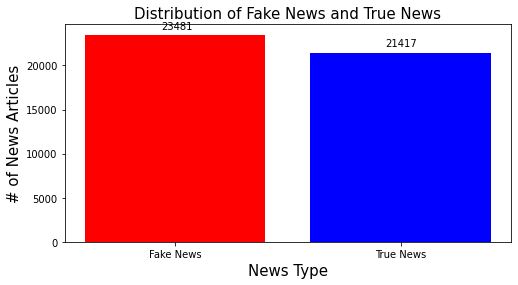

In [8]:
plt.figure(figsize=(8, 4))
plt.bar('Fake News', len(fake), color='red')
plt.bar('True News', len(real), color='blue')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)
plt.annotate(len(fake), # this is the text
                (0.01,23000), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center')
plt.annotate(len(real), # this is the text
                (1,21000), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center')
plt.show()

In [10]:
real.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


### News visualisation using wordcloud

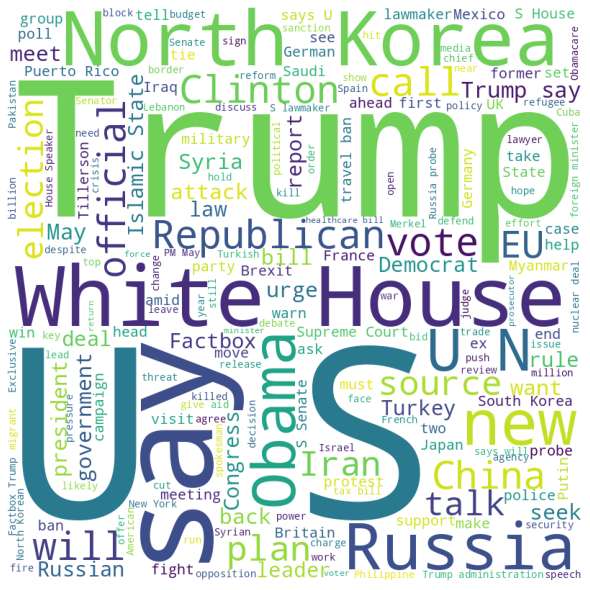

In [12]:
# real news
stopwords = set(STOPWORDS) 

words_li_true = list(real['title'])
string_of_words_true = " ".join(words_li_true)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(string_of_words_true) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

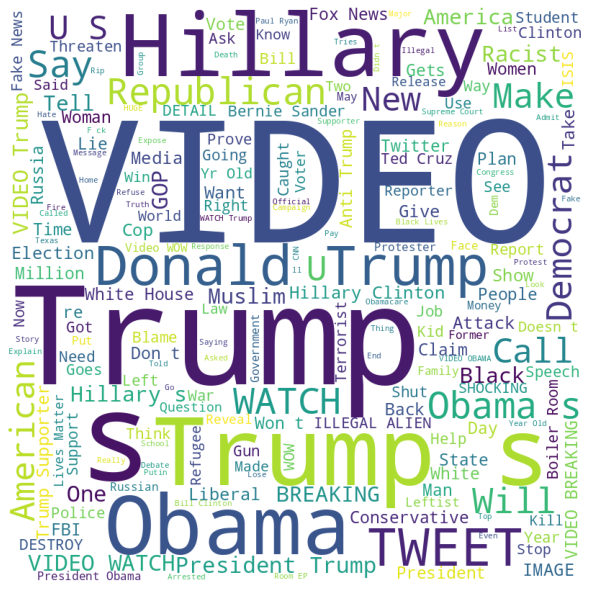

In [13]:
# fake news
words_li_fake = list(fake['title'])
string_of_words_fake = " ".join(words_li_fake)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(string_of_words_fake) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()